Change lmax of simulation to see effect on sky temperature data.

Theoretical lmax: beam with 1 deg sampling -> lmax = 179 \
sky: nside = 128 -> lmax = 256

Common lmax = 179

In [1]:
import jax
import jax.numpy as jnp

jax.config.update('jax_enable_x64', True)

import astropy.units as u
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import s2fft
from astropy.coordinates import EarthLocation
from astropy.time import Time
from pathlib import Path

import mistsim as ms

%matplotlib widget

In [3]:
DATA_DIR = Path("/home/christian/Documents/research/MIST/mistsim/notebooks/data/")

# beam
d = np.load(DATA_DIR / Path("beam.npz"))
freqs = d["freqs"]
gain = d["gain"]
theta = d["theta"]
print(gain.shape)

# sky
d = np.load(DATA_DIR / Path("haslam_galactic.npz"))
haslam = d["m"]
assert np.allclose(freqs, d["freqs"])  # check freqs match
print(haslam.shape)

(86, 181, 360)
(86, 196608)


In [5]:
beam = ms.Beam(gain, freqs, sampling="mwss", horizon=None)
sky = ms.Sky(haslam, freqs, sampling="healpix", coord="galactic")

In [7]:
# sim params
tstart = Time("2026-02-25 12:27")
tend = tstart + 1*u.sday  # one sidereal day
times = cro.utils.time_array(t_start=tstart, t_end=tend, N_times=240)

lon = -90.74750
lat = 79.41833
alt = 150


def get_sim(lmax):
    sim = ms.Simulator(
        beam,
        sky,
        times.jd,
        freqs,
        lon,
        lat,
        alt=alt,
        lmax=lmax,
        Tgnd=0,
    )
    return sim

In [9]:
sims = {}
tants = {}

lmax = 179
sim = get_sim(lmax)
sims[lmax] = sim
tants[lmax] = sim.sim()

In [10]:
sky_alm_eq = sim.sky.compute_alm_eq(world="earth")
beam_alm_eq = sim.compute_beam_eq()

sky_alm_eq = cro.utils.reduce_lmax(sky_alm_eq, sim.lmax)
beam_alm_eq = cro.utils.reduce_lmax(beam_alm_eq, sim.lmax)

In [67]:
plot_ix = -1
fplot = freqs[plot_ix]

_s = s2fft.inverse_jax(sky_alm_eq[plot_ix], sim._L, nside=64, sampling="healpix", reality=True)
_b = s2fft.inverse_jax(beam_alm_eq[plot_ix], sim._L, nside=64, sampling="healpix", reality=True)

In [68]:
rot = hp.Rotator(coord="gc")
haslam_eq = rot.rotate_map_alms(haslam[plot_ix])
haslam_eq64 = hp.ud_grade(haslam_eq, 64)

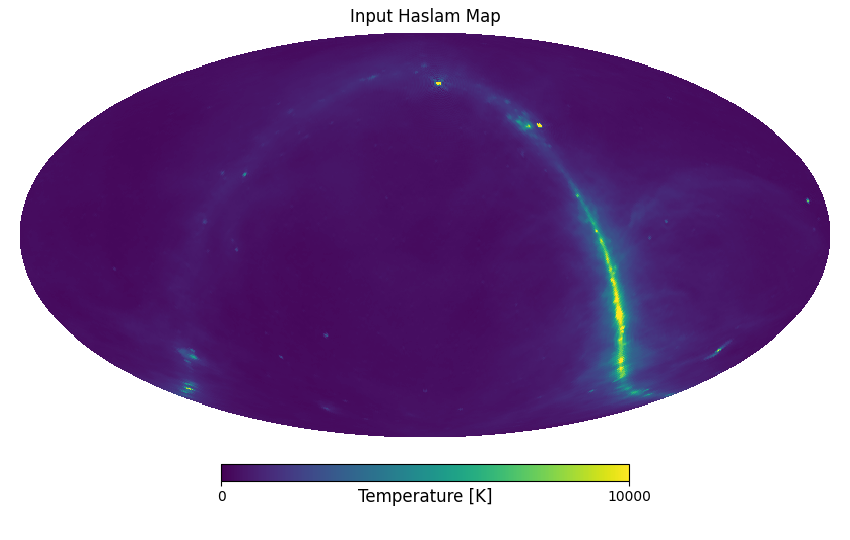

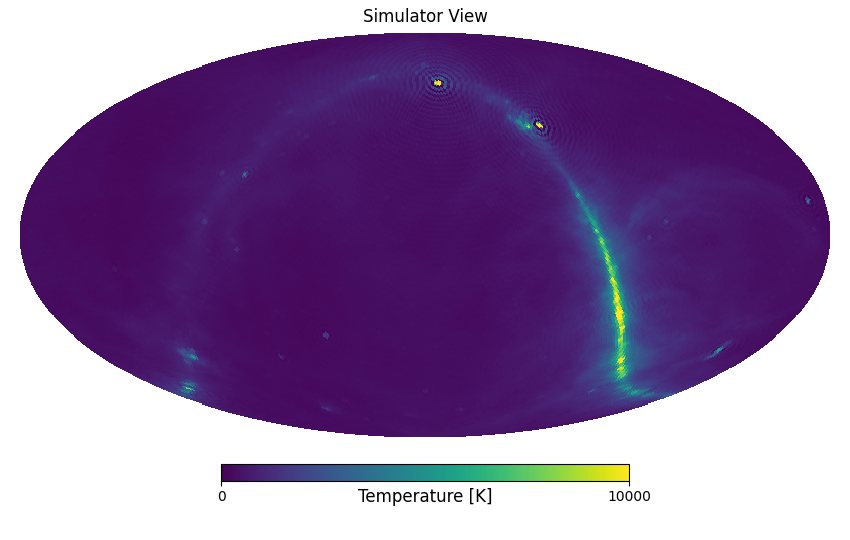

In [69]:
hp.mollview(haslam_eq, cbar=True, unit="Temperature [K]", min=0, max=1e4, title="Input Haslam Map")
plt.show()

hp.mollview(_s.real, cbar=True, unit="Temperature [K]", min=0, max=1e4, title="Simulator View")
plt.show()

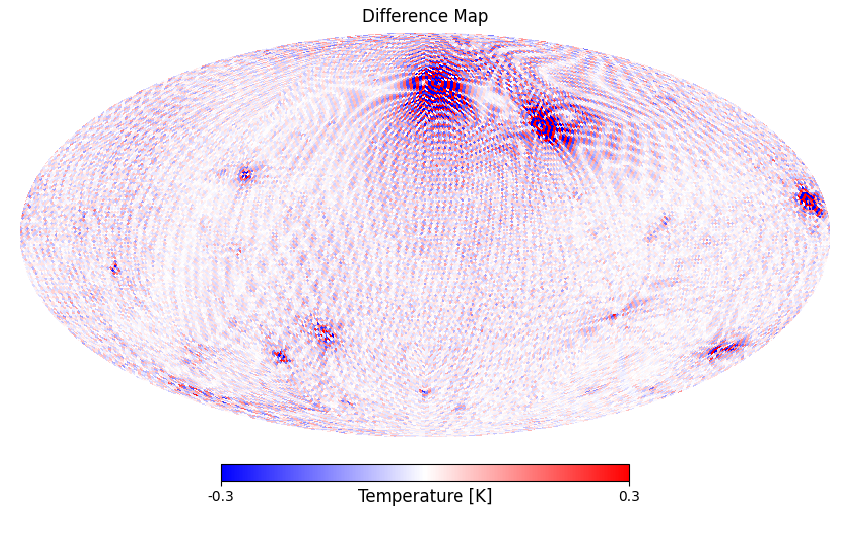

In [70]:
fsdiff = (haslam_eq64 - _s.real)/haslam_eq64
hp.mollview(fsdiff, cbar=True, unit="Temperature [K]", title="Difference Map", min=-0.3, max=0.3, cmap="bwr")
plt.show()

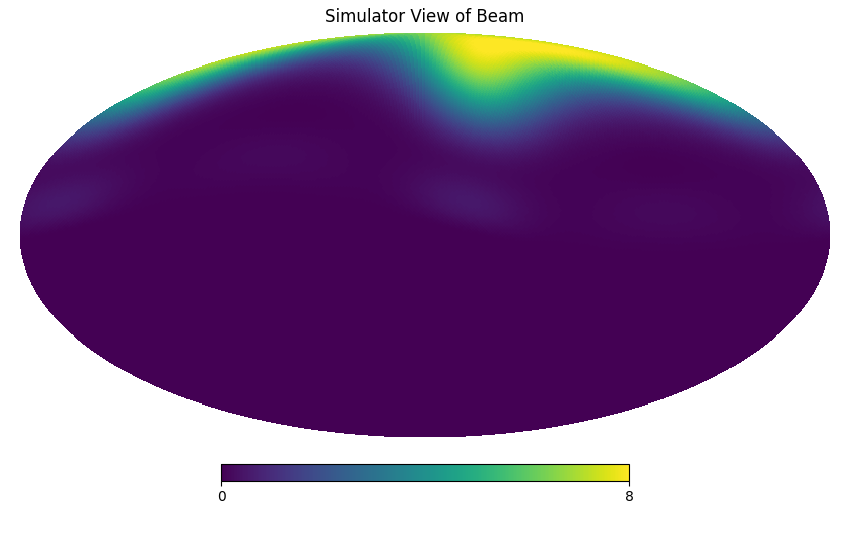

In [71]:
hp.mollview(_b.real, cbar=True, title="Simulator View of Beam", min=0, max=8)
plt.show()